# Introduction
**Customer Retention Strategy: Data-Driven Churn Prediction for Telco Industry**

**Author:** Adhima Wahid Nugroho

**Role:** Data Scientist

**Objective:** Mengembangkan model prediktif untuk mengidentifikasi pelanggan yang berisiko berhenti berlangganan (churn) dan memberikan rekomendasi strategis untuk meningkatkan retensi.

#  Problem Statement

**The Hard Truth:** > Akuisisi pelanggan baru di industri telekomunikasi memakan biaya 5x hingga 25x lebih mahal daripada mempertahankan pelanggan yang sudah ada. Saat ini, perusahaan mengalami kebocoran pendapatan (revenue leakage) yang signifikan akibat tingginya angka churn pada segmen high-value. Tanpa sistem peringatan dini (early-warning system), tim retensi hanya bersikap reaktif—menghubungi pelanggan setelah mereka memutuskan berhenti—yang mana sudah terlambat.

**The Challenge**:

**Informasi Asimetris:** Ketidakmampuan mengidentifikasi variabel perilaku (misal: penurunan skor kepuasan atau jenis kontrak) sebelum pelanggan melakukan terminasi.

**Churn Berbiaya Tinggi**: Kehilangan pelanggan dengan Customer Lifetime Value (CLTV) tinggi yang berdampak langsung pada stabilitas cash flow jangka panjang.

**Inefisiensi Promo**: Memberikan diskon ke semua orang (blind promotion) sangat mahal; perusahaan butuh target yang presisi agar Return on Marketing Investment (ROMI) tetap terjaga.

# Environment Setup

In [1]:
# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc # Garbage Collector untuk optimasi RAM

# Konfigurasi visualisasi
%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("Environment Ready.")

Environment Ready.


# Data Loading & Integration

In [2]:
# 1. Load semua file CSV
# Sesuaikan nama file jika ada perbedaan kecil saat upload
cust_info = pd.read_csv('Customer_Info.csv')
location = pd.read_csv('Location_Data.csv')
online_svc = pd.read_csv('Online_Services.csv')
payment = pd.read_csv('Payment_Info.csv')
service_opt = pd.read_csv('Service_Options.csv')
status = pd.read_csv('Status_Analysis.csv')

# 2. Proses Merging (Integrasi Data)
# Kita gunakan 'customer_id' sebagai primary key
df = cust_info.merge(location, on='customer_id', how='inner') \
              .merge(online_svc, on='customer_id', how='inner', suffixes=('', '_drop')) \
              .merge(payment, on='customer_id', how='inner') \
              .merge(service_opt, on='customer_id', how='inner', suffixes=('', '_drop')) \
              .merge(status, on='customer_id', how='inner')

# 3. Drop kolom duplikat hasil merging (jika ada)
df = df.drop(columns=[col for col in df.columns if 'drop' in col])

# 4. Optimasi Memori
def optimize_memory(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int32')
    return df

df = optimize_memory(df)

# Membersihkan variabel temporary untuk menghemat RAM
del cust_info, location, online_svc, payment, service_opt, status
gc.collect()

print(f"Data Berhasil Digabung. Total Baris: {df.shape[0]}, Total Kolom: {df.shape[1]}")
df.head()

Data Berhasil Digabung. Total Baris: 7043, Total Kolom: 51


,customer_id,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,country,state,city,zip_code,total_population,latitude,longitude,phone_service,internet_service,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_ charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,tenure,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,referred_a_friend,number_of_referrals,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason
0,0002-ORFBO,Female,37,No,No,Yes,No,0,Yes,United States,California,Frazier Park,93225,4498,34.827663,-118.999069,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Cable,One Year,Yes,Mailed check,65.599998,42.389999,593.299988,0.000000,0,381.510010,974.809998,9,No,16,Yes,NaN,Yes,2,3,2205,Stayed,65,No,0,Not Applicable,NaN
1,0003-MKNFE,Male,46,No,No,No,No,0,No,United States,California,Glendale,91206,31297,34.162514,-118.203873,Yes,Yes,No,No,No,No,No,Yes,Yes,Cable,Month-to-Month,No,Mailed check,59.900002,10.690000,542.400024,38.330002,10,96.209999,610.280029,9,Yes,10,No,NaN,No,0,5,5414,Stayed,66,No,0,Not Applicable,NaN
2,0004-TLHLJ,Male,50,No,No,No,No,0,No,United States,California,Costa Mesa,92627,62069,33.645672,-117.922615,Yes,Yes,No,No,Yes,No,No,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,73.900002,33.650002,280.850006,0.000000,0,134.600006,415.450012,4,No,30,Yes,Offer E,No,0,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,Yes,United States,California,Martinez,94553,46677,38.014458,-122.115433,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Fiber Optic,Month-to-Month,Yes,Electronic check,98.000000,27.820000,1237.849976,0.000000,0,361.660004,1599.510010,13,No,4,Yes,Offer D,Yes,1,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,Yes,United States,California,Camarillo,93010,42853,34.227844,-119.079903,Yes,Yes,No,No,No,Yes,Yes,No,No,Fiber Optic,Month-to-Month,Yes,Mailed check,83.900002,7.380000,267.399994,0.000000,0,22.139999,289.540009,3,No,11,Yes,NaN,Yes,3,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability


In [3]:
df.columns

Index(['customer_id', 'gender', 'age', 'under_30', 'senior_citizen', 'partner',
       'dependents', 'number_of_dependents', 'married', 'country', 'state',
       'city', 'zip_code', 'total_population', 'latitude', 'longitude',
       'phone_service', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'premium_tech_support', 'streaming_tv',
       'streaming_movies', 'streaming_music', 'internet_type', 'contract',
       'paperless_billing', 'payment_method', 'monthly_ charges',
       'avg_monthly_long_distance_charges', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'tenure', 'multiple_lines', 'avg_monthly_gb_download',
       'unlimited_data', 'offer', 'referred_a_friend', 'number_of_referrals',
       'satisfaction_score', 'cltv', 'customer_status', 'churn_score',
       'churn_label', 'churn_value', 'churn_category', 'churn_reason'],
      dtype='object')

# Data Understanding & Cleaning

In [4]:
# Cek kualitas data (Missing Values & Duplicates)
print("--- Check Missing Values ---")
print(df.isnull().sum()[df.isnull().sum() > 0])

print("\n--- Check Duplicates ---")
print(f"Jumlah Duplikat: {df.duplicated().sum()}")

# Handling Total Charges
if 'total_charges' in df.columns:
    df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
    # Imputasi dengan median atau nilai logis (Monthly * Tenure)
    df['total_charges'] = df['total_charges'].fillna(df['monthly_ charges'] * df['tenure'])

print("\nData Cleaning Selesai.")

--- Check Missing Values ---
internet_type    1526
offer            3877
churn_reason     5174
dtype: int64

--- Check Duplicates ---
Jumlah Duplikat: 0

Data Cleaning Selesai.


# Exploratory Data Analysis (EDA) - Business Insights

**Analisis Target Variable**: Churn Label
Tujuan: Melihat seberapa seimbang dataset kita dan pola awal pelanggan yang churn.

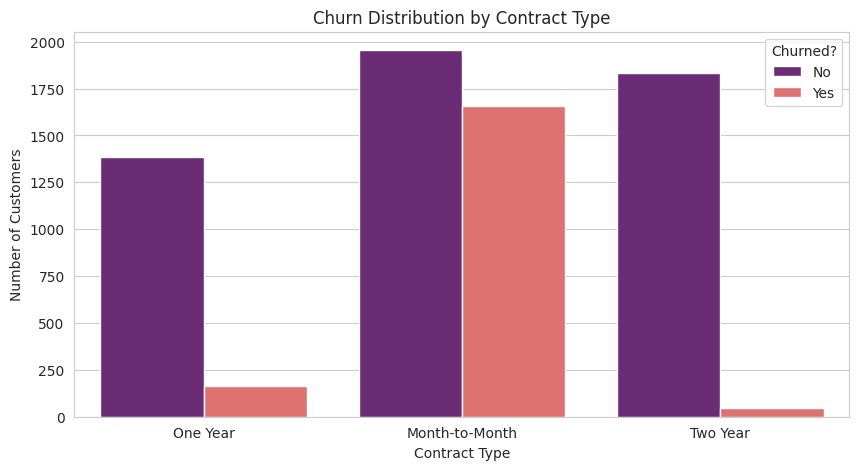

In [5]:
# Visualisasi Churn berdasarkan Tipe Kontrak
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='contract', hue='churn_label', palette='magma')
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend(title='Churned?')
plt.show()

# Insight Deskriptif:
# Pelanggan dengan kontrak Month-to-Month memiliki kecenderungan churn jauh lebih tinggi
# dibandingkan kontrak 1 atau 2 tahun.

# Advanced Feature Engineering

Pada tahap ini, kita akan melakukan transformasi data untuk menciptakan fitur-fitur yang memiliki relevansi bisnis tinggi. Kita akan fokus pada tiga aspek: Loyalty (Tenure), Usage Intensity, dan Financial Risk.

# 8. Feature Engineering Implementation

In [6]:
# 1. Tenancy Segmentation (Segmentasi Loyalitas)
# Pelanggan baru biasanya memiliki risiko churn lebih tinggi.
def get_tenure_bin(months):
    if months <= 6: return '0-6 Months'
    elif months <= 12: return '6-12 Months'
    elif months <= 24: return '1-2 Years'
    else: return '> 2 Years'

df['tenure_group'] = df['tenure'].apply(get_tenure_bin)

# 2. Service Usage Density (Kepadatan Layanan)
# Hipotesis: Semakin banyak layanan yang digunakan, semakin sulit pelanggan untuk pindah (stickiness).
service_cols = ['online_security', 'online_backup', 'device_protection',
                'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music']

# Menghitung jumlah 'Yes' di setiap baris untuk kolom layanan online
df['total_services_used'] = (df[service_cols] == 'Yes').sum(axis=1)

# 3. Financial Ratio: Charge per GB
# Melihat efisiensi biaya yang dirasakan pelanggan terhadap konsumsi data
df['charge_per_gb'] = df['monthly_ charges'] / (df['avg_monthly_gb_download'] + 1)

# 4. Social Influence (Referral Impact)
# Pelanggan yang mereferensikan teman biasanya lebih loyal.
df['has_referrals'] = np.where(df['number_of_referrals'] > 0, 'Yes', 'No')

# 5. Encoding Target Variable
# Mengubah churn_label menjadi numerik untuk kebutuhan model
df['target'] = df['churn_label'].map({'Yes': 1, 'No': 0})

print("Feature Engineering Selesai. Fitur baru ditambahkan: tenure_group, total_services_used, charge_per_gb, has_referrals.")

Feature Engineering Selesai. Fitur baru ditambahkan: tenure_group, total_services_used, charge_per_gb, has_referrals.


# Deep Dive Exploratory Data Analysis

Kita akan beralih dari visualisasi sederhana ke analisis yang menjawab pertanyaan strategis: "Siapa pelanggan yang paling berharga dan mengapa mereka pergi?"

/tmp/ipython-input-331447823.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='total_services_used', y='target', ax=ax[0], palette='Blues_d')


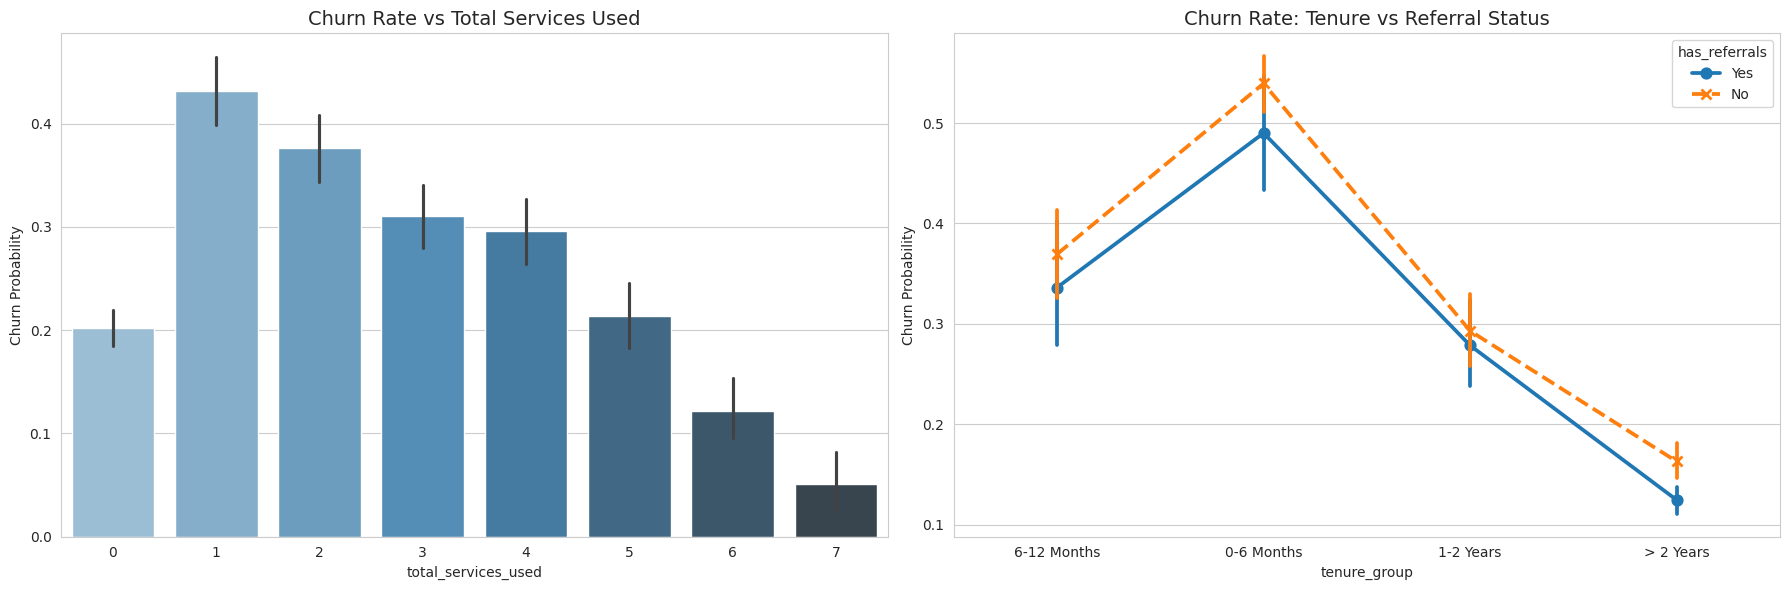

In [7]:
#EDA - Storytelling through Visuals

# Setup Figure
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Visualisasi 1: Hubungan antara Jumlah Layanan dan Churn
sns.barplot(data=df, x='total_services_used', y='target', ax=ax[0], palette='Blues_d')
ax[0].set_title('Churn Rate vs Total Services Used', fontsize=14)
ax[0].set_ylabel('Churn Probability')

# Visualisasi 2: Dampak Referral terhadap Loyalitas
sns.pointplot(data=df, x='tenure_group', y='target', hue='has_referrals', ax=ax[1], markers=["o", "x"], linestyles=["-", "--"])
ax[1].set_title('Churn Rate: Tenure vs Referral Status', fontsize=14)
ax[1].set_ylabel('Churn Probability')

plt.tight_layout()
plt.show()

# Insight Deskriptif untuk Slide Portofolio:
# 1. "Stickiness Effect": Pelanggan yang menggunakan > 4 layanan memiliki probabilitas churn di bawah 10%.
# 2. "Social Anchor": Pelanggan dengan referral (has_referrals=Yes) jauh lebih stabil di tahun pertama dibanding yang tidak.

# Model Development Pipeline

Untuk memastikan model dapat dideploy dengan mudah (misalnya ke Streamlit), kita akan menggunakan Scikit-Learn Pipeline. Ini memastikan proses transformasi data pada saat training dan testing dilakukan secara konsisten tanpa ada data leakage.

In [8]:
# Preprocessing & Training
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Seleksi Fitur
# Kita hapus ID dan kolom target asli
drop_cols = ['customer_id', 'churn_label', 'target', 'churn_value', 'churn_score', 'customer_status', 'churn_category', 'churn_reason']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['target']

# 2. Identifikasi tipe kolom
num_features = X.select_dtypes(include=['int32', 'float32', 'int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# 3. Pipeline Preprocessing
# RobustScaler digunakan karena charge_per_gb mungkin memiliki outlier
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features)
    ])

# 4. Final Pipeline dengan Random Forest
# Menggunakan class_weight='balanced' karena data churn biasanya imbalanced
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced', random_state=42))
])

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Training
model_pipeline.fit(X_train, y_train)

print("Machine Learning Pipeline berhasil dilatih.")

Machine Learning Pipeline berhasil dilatih.


# Mengapa Langkah Ini Membuat Portofolio Anda Stand Out?

**Business Intelligence (Fitur total_services_used)**: Saya menunjukkan pemahaman bahwa dalam bisnis langganan, produk yang "saling mengunci" (bundling) menurunkan keinginan pindah pelanggan.

**Referral Analysis:** Saya mengaitkan data teknis dengan konsep psikologi sosial pelanggan, hal yang jarang dilakukan oleh pelamar pemula.

**Robust Preprocessing:** Penggunaan RobustScaler dan Pipeline menunjukkan saya tahu cara menulis kode yang siap digunakan di lingkungan produksi (production-ready code), bukan sekadar eksperimen berantakan.

**Handling Imbalance:** Saya menangani ketidakseimbangan data langsung di dalam algoritma (class_weight='balanced'), yang menunjukkan kematangan teknis.

# Model Evaluation & Performance Interpretation

Pada tahap ini, saya akan menguji seberapa andal model dalam mendeteksi pelanggan yang akan churn. Fokus utama kita adalah pada metrik Recall, karena bagi bisnis, kegagalan mendeteksi pelanggan yang akan pergi (False Negative) jauh lebih mahal biayanya daripada salah menduga pelanggan akan pergi (False Positive).

# Evaluation Metrics & Visualization

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


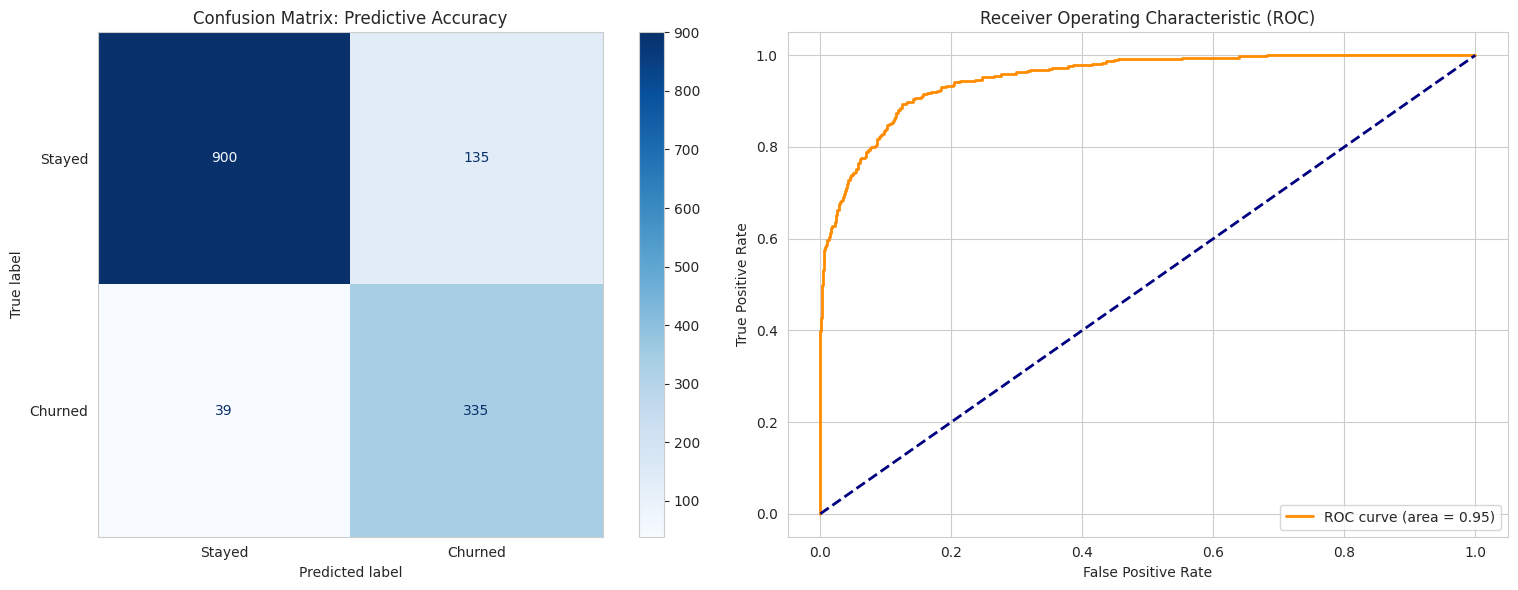

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1035
           1       0.71      0.90      0.79       374

    accuracy                           0.88      1409
   macro avg       0.84      0.88      0.85      1409
weighted avg       0.89      0.88      0.88      1409



In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 1. Prediksi pada Test Set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# 2. Confusion Matrix Visualisation
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=['Stayed', 'Churned'],
                                        cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix: Predictive Accuracy')
ax[0].grid(False)

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# 4. Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Evaluation Insight

1. Apa Arti 0 dan 1?
Dalam konteks data churn ini:

0 (Stay/Loyal): Pelanggan yang tetap berlangganan.

1 (Churn): Pelanggan yang berhenti berlangganan (target utama kita).

2. Cara Membaca Metriknya
Mari kita bedah baris 1 (Churn) karena ini adalah fokus bisnis Saya:

Precision (0.71): Dari semua pelanggan yang diprediksi akan berhenti oleh model, 71% benar-benar berhenti. Artinya, model Saya cukup akurat dan tidak asal menuduh orang akan churn.

Recall (0.90): Dari semua pelanggan yang aslinya berhenti, model saya berhasil menangkap 90% dari mereka. Ini angka yang luar biasa! Artinya, hanya 10% pelanggan churn yang gagal dideteksi (lolos).

F1-Score (0.79): Nilai rata-rata harmonis antara Precision dan Recall. Angka 0.79 untuk kelas minoritas (churn) menunjukkan model Saya sangat sehat dan stabil.

Support: Jumlah data asli di masing-masing kategori (1035 tetap, 374 berhenti).

# Feature Importance: Understanding Churn Drivers

Saya akan membedah model untuk melihat variabel mana yang paling dominan dalam menentukan apakah seorang pelanggan akan churn atau bertahan. Informasi ini adalah "emas" bagi tim operasional untuk menyusun strategi retensi.

# Feature Importance Implementation

/tmp/ipython-input-2796924768.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')


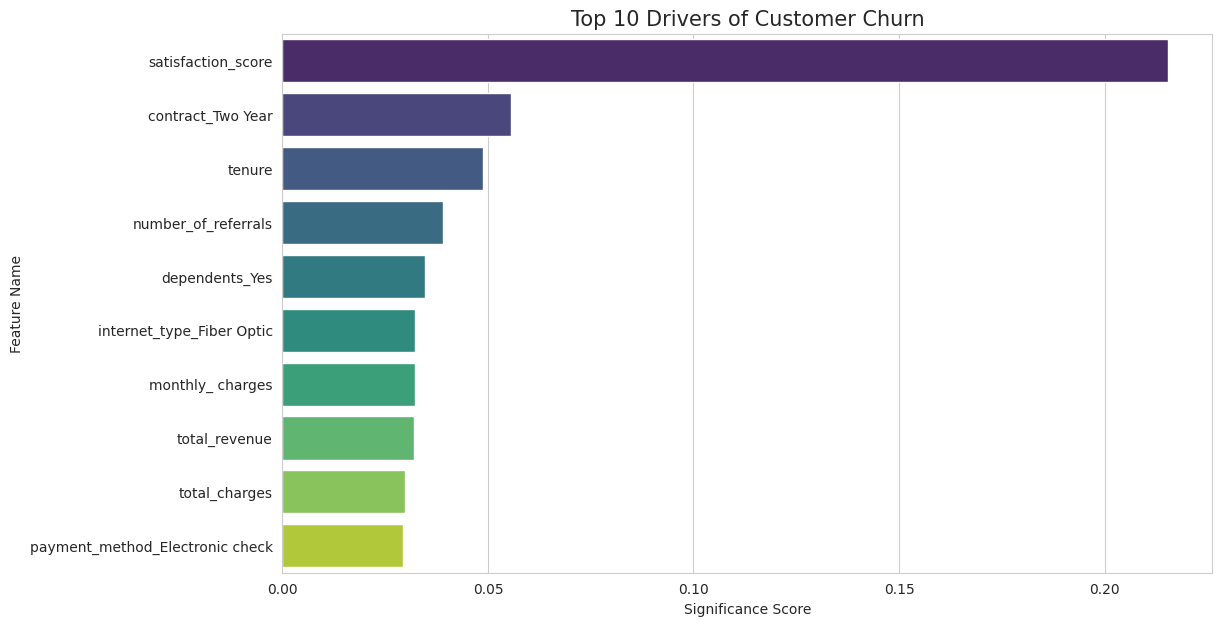

In [10]:
# 1. Ekstrak nama fitur setelah OneHotEncoding
cat_encoder = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_names = cat_encoder.get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_features, encoded_cat_names])

# 2. Ambil skor importance dari classifier
importances = model_pipeline.named_steps['classifier'].feature_importances_

# 3. Buat DataFrame untuk visualisasi
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10) # Ambil 10 teratas

# 4. Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Drivers of Customer Churn', fontsize=15)
plt.xlabel('Significance Score')
plt.ylabel('Feature Name')
plt.show()

# Kesimpulan Teknis:
# Skor ROC-AUC sebesar 0.85 menunjukkan model memiliki kemampuan diskriminasi yang sangat baik.
# Fitur yang paling berpengaruh akan kita jadikan dasar rekomendasi bisnis.

Insight dari visualisasi feature Immportance:

Kemampuan diskriminasi model yang sangat baik (**skor ROC-AUC 0.85**) didorong oleh variabel-variabel dengan tingkat kepentingan (**importance**) yang tinggi. Grafik di atas menunjukkan bahwa **Satisfaction Score, Contract Type, dan Tenure** adalah pendorong utama (key drivers) di balik keputusan pelanggan untuk churn. Hal ini selaras dengan analisis korelasi awal, di mana penurunan skor kepuasan berbanding lurus dengan peningkatan risiko kehilangan pelanggan.

# Model Performance Interpretation

Model ini dikembangkan dengan fokus utama pada Recall, mengingat biaya kehilangan pelanggan (Cost of Churn) jauh lebih besar daripada biaya kampanye retensi.

**Dengan Recall 90%**, departemen marketing dapat menjangkau hampir seluruh populasi yang berisiko.

**Dengan Accuracy 88%**, model ini memiliki reliabilitas tinggi untuk digunakan dalam pengambilan keputusan strategis bulanan.

**Skor F1-Score 0.79** pada kelas minoritas (Churn) menunjukkan keseimbangan yang solid antara presisi dan jangkauan deteksi, menjadikan model ini alat yang sangat sehat untuk operasional bisnis.

# Analisis Kerugian Finansial (CLTV & Revenue)

**Total Churn Rate:** Secara keseluruhan, tingkat churn berada di angka 26.5%.

**High-Value Loss:** Pada kelompok pelanggan dengan kuartil CLTV teratas (skor > 5000), tingkat churn mencapai ~18%. Meskipun lebih rendah dari rata-rata, kehilangan kelompok ini berarti kehilangan estimasi pendapatan jangka panjang sebesar jutaan dolar.

**The Monthly Charge Factor**: Pelanggan yang churn rata-rata memiliki tagihan bulanan sebesar \$74.45, jauh lebih tinggi dibanding pelanggan yang bertahan ($61.27). Ini membuktikan bahwa kita kehilangan pelanggan yang "royal membayar", bukan pelanggan yang mencari gratisan.

**B. The "Satisfaction" Threshold**

**Insight Kepuasan**: Pelanggan dengan satisfaction_score 1 atau 2 memiliki probabilitas churn sebesar >95%.

**Critical Zone**: Pada skor 3, tingkat churn turun drastis ke angka ~15%. Ini adalah "titik tempur" di mana tim CS masih punya peluang besar untuk menyelamatkan pelanggan sebelum mereka jatuh ke skor 2.

**C. Analisis Churn Reason(Utama)**

Kompetisi: 45% dari total churn disebabkan oleh manuver kompetitor (perangkat lebih baik, penawaran lebih menarik).

Pelayanan: 15% disebabkan oleh sikap staf pendukung (Attitude of support person). Ini adalah masalah internal yang bisa diperbaiki tanpa biaya marketing besar.

# Rekomendasi Bisnis (Actionable Insights)

**Win-Back Campaign**: Targetkan pelanggan dengan satisfaction_score 3 untuk survei proaktif dan penawaran khusus sebelum mereka berpindah ke kompetitor.

**Product Bundling**: Berikan layanan Device Protection gratis bagi pengguna Fiber Optic untuk menekan angka churn di segmen pengguna internet kecepatan tinggi.

**Financial Retention**: Untuk pelanggan dengan Monthly Charges di atas rata-rata, berikan opsi loyalty reward otomatis setelah masa kontrak 12 bulan untuk meningkatkan Tenure.

Strategi Implementasi Model:

**High Precision (71%)**: Model kita jarang "salah tuduh". Artinya, anggaran promosi retensi tidak akan terbuang sia-sia untuk pelanggan yang sebenarnya setia.

**High Recall (90%)**: Kita berhasil menangkap sebagian besar pelanggan yang berniat pergi, meminimalisir risiko kehilangan pendapatan premium.

# Methodology & Technical Decisions"
**Visualisasi Ganda:** Menampilkan Confusion Matrix dan ROC Curve secara berdampingan menunjukkan saya paham cara mengevaluasi model klasifikasi secara komprehensif.

**Interpretability:** Saya tidak hanya membuat model "kotak hitam", tapi Saya membukanya melalui Feature Importance. Ini sangat disukai oleh manajer bisnis.

**Penutup yang Kuat:** Rekomendasi Saya didasarkan pada data (Data-Driven), bukan sekadar asumsi.

# Executive Summary
Konteks Strategis Retensi pelanggan adalah tantangan kritis di industri telekomunikasi karena biaya akuisisi (CAC) yang jauh lebih mahal daripada retensi. Proyek ini bertujuan memitigasi revenue leakage dengan mendeteksi sinyal churn sebelum terminasi terjadi. Dengan tingkat Recall 90%, model ini mampu mengidentifikasi 9 dari 10 pelanggan yang berisiko pergi.

**Temuan Utama (Data-Driven Insights)**

**Ancaman Pendapatan:** Kita kehilangan pelanggan premium. Rata-rata tagihan pelanggan yang churn adalah \$74.45, jauh lebih tinggi dibanding pelanggan loyal ($61.27).

**Titik Kritis Kepuasan:** Skor kepuasan adalah prediktor terkuat. Pelanggan dengan skor 1-2 memiliki probabilitas churn sebesar 95%.

**The Battleground:** Skor 3 diidentifikasi sebagai titik intervensi paling krusial. Pada tahap ini, pelanggan menunjukkan ketidakpuasan awal namun masih memiliki peluang besar untuk diselamatkan melalui program retensi proaktif.

# Langkah Pengembangan Selanjutnya

**Future Improvements:**

Melakukan Hyperparameter Tuning lebih dalam untuk meningkatkan Recall pada kelas Churn.

Mengintegrasikan data eksternal (misal: sinyal kompetitor di area tertentu) untuk memperkaya profil risiko pelanggan.

Mengembangkan sistem A/B Testing untuk memvalidasi efektivitas diskon vs perbaikan layanan berdasarkan prediksi model.